## 🏆 Kaggle Competition: Feature Imputation with a Heat Flux Dataset 

### 📌 Importamos las librerías necesarias para nuestro proyecto

In [242]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math
from plotly.subplots import make_subplots

# Imputaciones de missing values columnas categoricas
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Imputaciones de missing values
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer

# Partición de datos
from sklearn.model_selection import train_test_split


# Colores
DF_CMAP = sns.light_palette("#8C92AC", as_cmap=True)
FONT_COLOR = "#2D3142"
BACKGROUND_COLOR = "#F6F5F5"
NOTEBOOK_PALETTE = {
    "Coral": "#FF7F51",
    "DarkNavy": "#2D3142",
    "SlateBlue": "#8C92AC",
}

## Set Plot Parameters       
plt.style.use("Solarize_Light2")
color_pal = ["#4CAF50", "#780060", "#FFBF00", "#6495ED", "#DE3163",
             "#922710", "#C99BE8", "#FF8700", "#E0FF00", "#2E00FF"]

### 📌 Importamos los datos

In [243]:
sample = pd.read_csv("../data/raw_data/sample_submission.csv")
data = pd.read_csv("../data/raw_data/data.csv")
origin = pd.read_csv('../data/raw_data/original.csv')

### 📌 Hacemos un Análisis Exploratorio de Datos (EDA) 

In [244]:
# Tener en cuenta que los datos del dataset original están dentro del dataset generado
print(data.shape)
print(origin.shape)

(31644, 10)
(1865, 10)


#### Estudiamos similitudes entre el dataset original y el generado

In [245]:
data.describe().T

count          mean          std      min        25%  \
id                   31644.0  15821.500000  9134.980296   0.0000  7910.7500   
pressure [MPa]       27192.0     10.640747     4.333683   0.1000     6.8900   
mass_flux [kg/m2-s]  26853.0   3068.011023  1777.032080   0.0000  1519.0000   
x_e_out [-]          21229.0     -0.000453     0.100911  -0.8667    -0.0466   
D_e [mm]             26156.0      8.629255     5.185692   1.0000     5.0000   
D_h [mm]             27055.0     14.174330    19.838489   1.0000     5.6000   
length [mm]          26885.0    832.987391   672.299239  10.0000   318.0000   
chf_exp [MW/m2]      31644.0      3.796985     1.983991   0.8000     2.4000   

                            50%         75%        max  
id                   15821.5000  23732.2500  31643.000  
pressure [MPa]          11.0700     13.7900     20.680  
mass_flux [kg/m2-s]   2731.0000   4069.0000   7975.000  
x_e_out [-]              0.0038      0.0648      0.232  
D_e [mm]                 7.8000     10.8000     37.500  
D_h [mm]                10.0000     11.5000    120.000  
length [mm]            610.0000    914.0000   3048.000  
chf_exp [MW/m2]          3.4000      4.6000     19.300

In [246]:
origin.describe().T

count         mean          std      min        25%  \
id                   1865.0   933.000000   538.523444   1.0000   467.0000   
pressure [MPa]       1865.0    10.010949     4.282715   0.1000     6.8900   
mass_flux [kg/m2-s]  1865.0  2862.647721  1656.412247   0.0000  1519.0000   
x_e_out [-]          1865.0     0.016179     0.117575  -0.8667    -0.0483   
D_e [mm]             1865.0     9.417212     6.333807   1.0000     5.6000   
D_h [mm]             1865.0    16.167721    21.182870   1.0000     5.6000   
length [mm]          1865.0   911.340483   726.718974  10.0000   432.0000   
chf_exp [MW/m2]      1865.0     3.854638     1.985535   0.8000     2.4000   

                           50%        75%       max  
id                    933.0000  1399.0000  1865.000  
pressure [MPa]         10.3400    13.7900    20.680  
mass_flux [kg/m2-s]  2590.0000  3933.0000  7975.000  
x_e_out [-]             0.0244     0.1006     0.232  
D_e [mm]                8.5000    11.1000    37.500  
D_h [mm]               10.3000    15.2000   120.000  
length [mm]           625.0000  1778.0000  3048.000  
chf_exp [MW/m2]         3.5000     4.8000    19.300

####  💡Creamos la función summary_table para obtener un resumen de los datos

In [247]:
def summary_table(df):
    print(f'data shape: {df.shape}')
    df = df.drop('id', axis=1)
    summ = pd.DataFrame(index=df.columns)
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['mean'] = desc['mean'].values
    summ['std'] = desc['std'].values
    summ['median'] = desc['50%'].values
    return summ

In [248]:
# Summary table ORIGIN
summary_table(origin)

data shape: (1865, 10)


%missing         mean          std  median
author                    0.0          NaN          NaN     NaN
geometry                  0.0          NaN          NaN     NaN
pressure [MPa]            0.0    10.010949     4.282715   10.34
mass_flux [kg/m2-s]       0.0  2862.647721  1656.412247  2590.0
x_e_out [-]               0.0     0.016179     0.117575  0.0244
D_e [mm]                  0.0     9.417212     6.333807     8.5
D_h [mm]                  0.0    16.167721     21.18287    10.3
length [mm]               0.0   911.340483   726.718974   625.0
chf_exp [MW/m2]           0.0     3.854638     1.985535     3.5

In [249]:
# Summary table GENERATED
summary_table(data)

data shape: (31644, 10)


%missing         mean         std  median
author               15.876627          NaN         NaN     NaN
geometry             17.380862          NaN         NaN     NaN
pressure [MPa]       14.069018    10.640747    4.333683   11.07
mass_flux [kg/m2-s]  15.140311  3068.011023  1777.03208  2731.0
x_e_out [-]          32.913032    -0.000453    0.100911  0.0038
D_e [mm]             17.342940     8.629255    5.185692     7.8
D_h [mm]             14.501959     14.17433   19.838489    10.0
length [mm]          15.039186   832.987391  672.299239   610.0
chf_exp [MW/m2]       0.000000     3.796985    1.983991     3.4

In [250]:
# Representacion gráfica de los valores perdidos en el target
fig = px.pie(
    data.assign(x_e_out_missing=data["x_e_out [-]"].isna().astype(str)),
    names="x_e_out_missing",
    height=520,
    width=840,
    hole=0.65,
    title="<b>Variable objetivo - x_e_out [-] - Missing Values</b>",
    color_discrete_sequence=["#2D3142", "#008080"],
)
fig.update_layout(
    font_color=FONT_COLOR,
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    showlegend=False,
)
fig.add_annotation(
    x=0.5,
    y=0.5,
    align="center",
    xref="paper",
    yref="paper",
    showarrow=False,
    font_size=22,
    text="x_e_out [-]<br>Missing Values",
)
fig.update_traces(
    hovertemplate=None,
    textposition="outside",
    texttemplate="%{label}<br>%{value} - %{percent}",
    textfont_size=16,
    rotation=20,
    marker_line_width=15,
    marker_line_color=BACKGROUND_COLOR,
)
fig.show()

#### 💡La forma en que se generan los valores nulos en un conjunto de datos puede ser importante a la hora de decidir cómo manejarlos: **Vamos a ver si los valores nulos se han generado de forma aleatoria o se han generado de forma sistemática.**

Text(0.5, 1.0, 'Matriz de valores nulos')

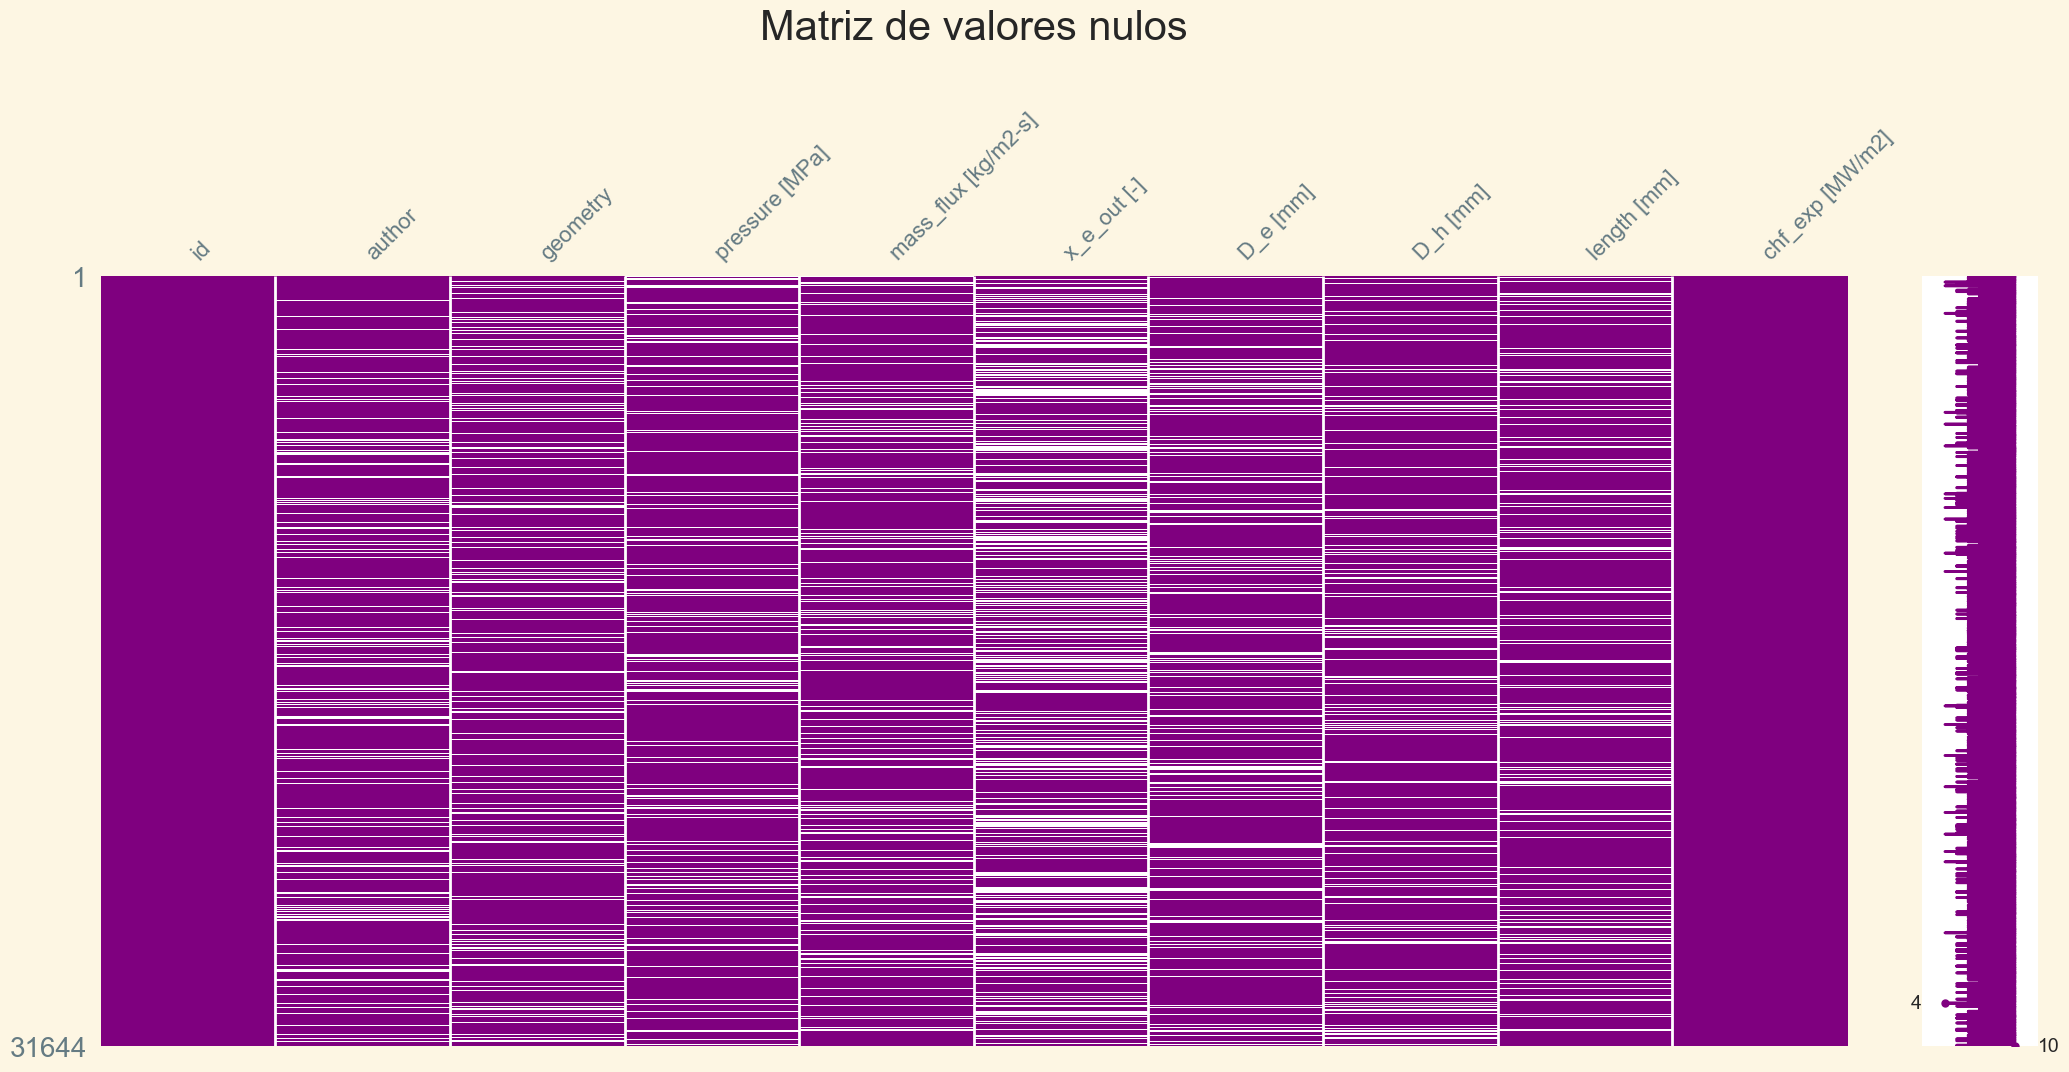

In [251]:
'''
Según esta matriz de valores nulos, éstos están dispersos de manera uniforme en todas las columnas,
por lo que no se puede eliminar ninguna de ellas. Además, esto puede indicar que los missing values están ausentes de manera aleatoria.
Este tipo de distribución permite utilizar técnicas generales de imputación de valores faltantes, como la imputación media o mediana, 
para completar los datos faltantes. Sin embargo, siempre es recomendable realizar un análisis más profundo y considerar el contexto 
específico del problema antes de tomar decisiones sobre cómo manejar los valores nulos.
'''
import missingno as msno
msno.matrix(data, color=(0.5, 0, 0.5)).set_title("Matriz de valores nulos",fontsize=30, pad=50)

#### 📊 Veamos la correlación entre las variables de nuestro conjunto de datos

##### **✔️ Variables numéricas**

In [252]:
# Seleccionamos las columnas que son de tipo numérico
num_cols = data.select_dtypes(include=np.number).columns.tolist()
num_cols.remove('id')
# Seleccionamos las columnas que son de tipo categórico
cat_cols = data.select_dtypes(include='object').columns.tolist()
# Todas las columnas
all_features = num_cols + cat_cols 

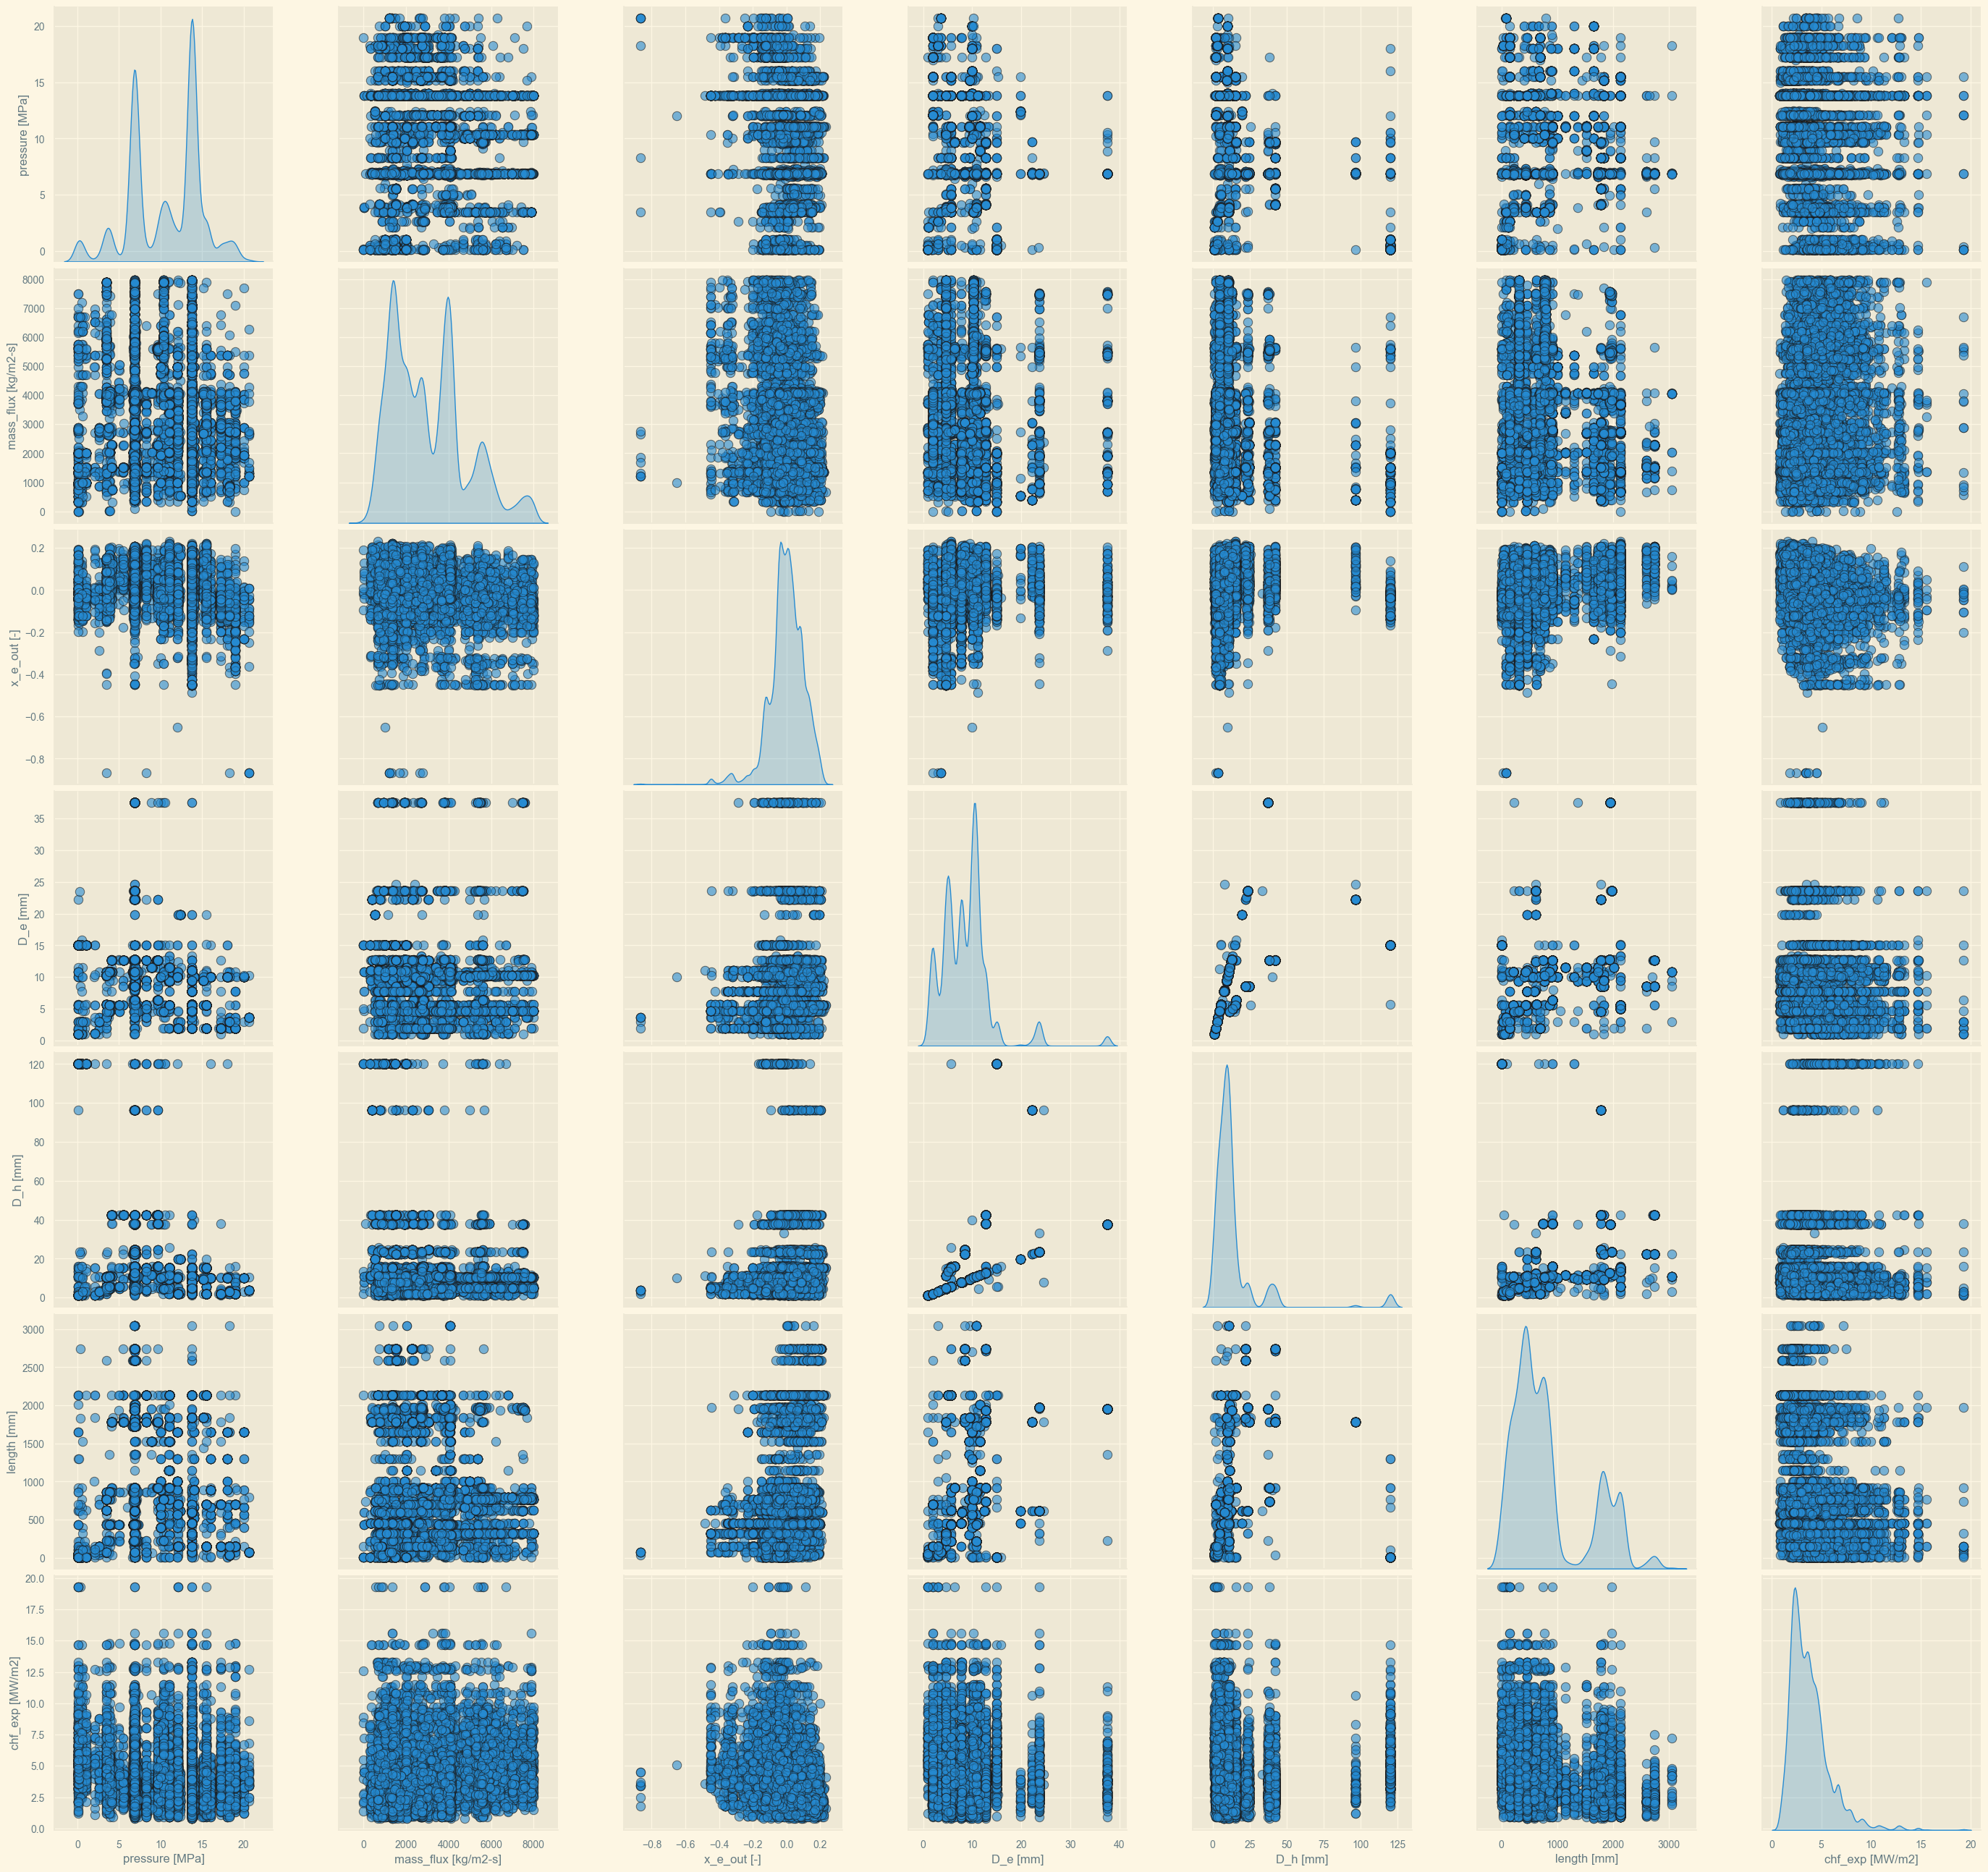

In [71]:
g = sns.pairplot(data[num_cols], diag_kind='kde', plot_kws={'alpha': 0.6, 's': 80, 'edgecolor': 'k'}, height=4)
g.fig.subplots_adjust(top=0.93, wspace=0.3)

# Mostrar el gráfico
plt.show()

#### 💡Destacamos las columnas que mantienen una clara relación lineal entre ellas

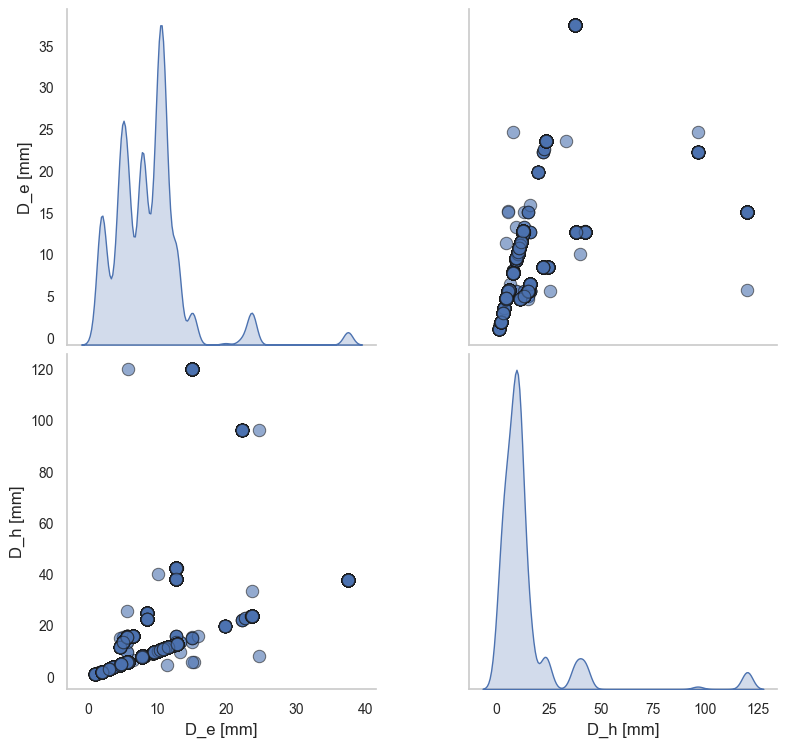

In [253]:
# Configurar el estilo de los ejes x e y para las columnas seleccionadas
sns.set(style='ticks', rc={'axes.labelsize': 12, 'xtick.labelsize': 10, 'ytick.labelsize': 10})
sns.set_style("whitegrid", {'axes.grid': False})

# Lista de columnas que deseas resaltar
columnas_destacadas = ['D_e [mm]', 'D_h [mm]']

# Crear el pairplot con los parámetros deseados
g = sns.pairplot(data[num_cols], vars=columnas_destacadas, diag_kind='kde',
                 plot_kws={'alpha': 0.6, 's': 80, 'edgecolor': 'k'}, height=4)
g.fig.subplots_adjust(top=0.93, wspace=0.3)

# Mostrar el gráfico
plt.show()

In [212]:
#  representamos graficamente la correlación entre las variables
data_without_id = data.drop('id', axis=1)
corr_data = data_without_id.corr()
corr_data.style.background_gradient(cmap='coolwarm')

In [213]:
origin_without_id = origin.drop('id', axis=1)
corr_origin = origin_without_id.corr()
corr_origin.style.background_gradient(cmap='coolwarm')

* A primera vista, no parece haber una correlación lineal entre las variables numéricas, excepto por ``D_h [mm]`` vs ``D_e [mm]``, que parecen tener una correlación lineal positiva de **0.49**

### :eyes: Vamos a comparar la distribución de las variables numéricas entre los datos originales y los datos generados.

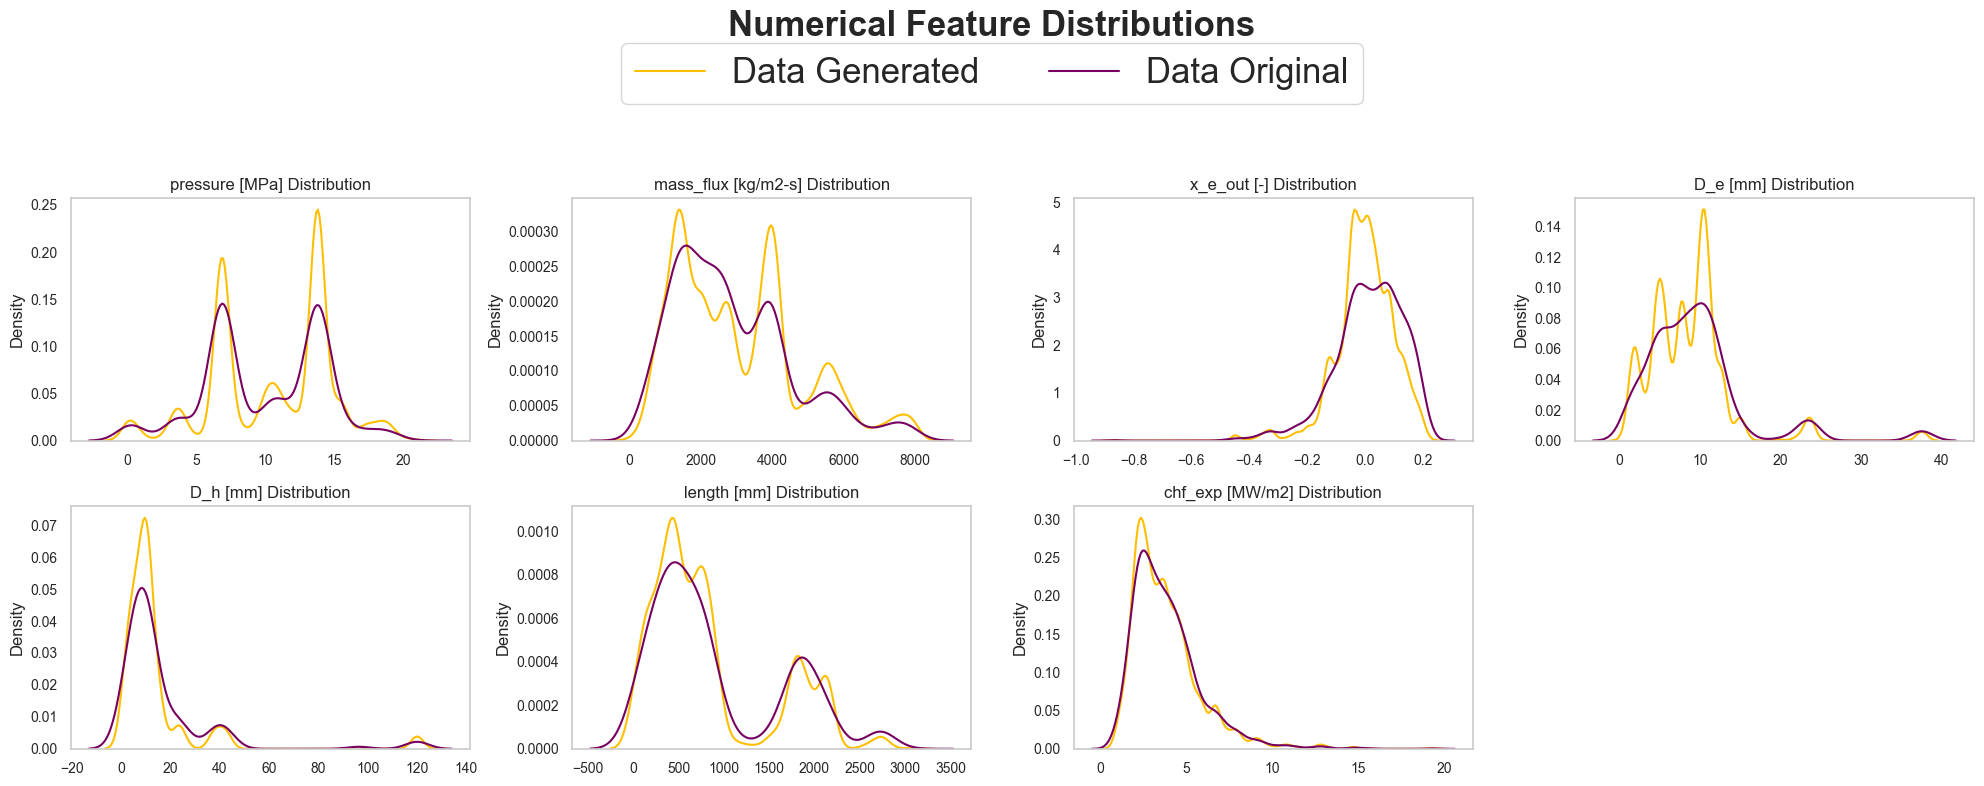

In [214]:
# check numerical variables' distribution

features = num_cols
n_bins = 50
histplot_hyperparams = {
    'kde':True,
    'alpha':0.4,
    'stat':'percent',
    'bins':n_bins
}

columns = features
n_cols = 4
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
ax = ax.flatten()

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    sns.kdeplot(
        data[column], label='Data Generated',
        ax=ax[i], color=color_pal[2]
    )
    
    sns.kdeplot(
        origin[column], label='Data Original',
        ax=ax[i], color=color_pal[1]
    )
    
    
    # titles
    ax[i].set_title(f'{column} Distribution');
    ax[i].set_xlabel(None)
    
    # remove axes to show only one at the end
    plot_axes = [ax[i]]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        handles += plot_ax.get_legend_handles_labels()[0]
        labels += plot_ax.get_legend_handles_labels()[1]
        plot_ax.legend().remove()
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')
    
fig.suptitle(f'Numerical Feature Distributions\n\n\n', ha='center',  fontweight='bold', fontsize=25)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=25, ncol=3)
plt.tight_layout()

#### 🔍 La distribución de los datos generados es muy similar a la distribución de los datos originales, a pesar de los missing values.

#### Observaciones:

* **En los casos en los que las variables numéricas no siguen una distribución normal, asignar medidas como media, mediana o moda puede no ser la mejor estrategia.**

* **Algunas estrategias a elegir para estos casos podría ser (K-Nearest Neighbors, KNN): Esta técnica consiste en encontrar los vecinos más cercanos en función de las variables existentes y utilizar los valores de esos vecinos para imputar los valores faltantes. Es una técnica no paramétrica que puede ser útil cuando las variables tienen múltiples modas o no siguen una distribución específica.**

##### **✔️ Variables categóricas**: relación entre D_e [mm] y D_h [mm] en función de 'geometry'

##### AUTHOR

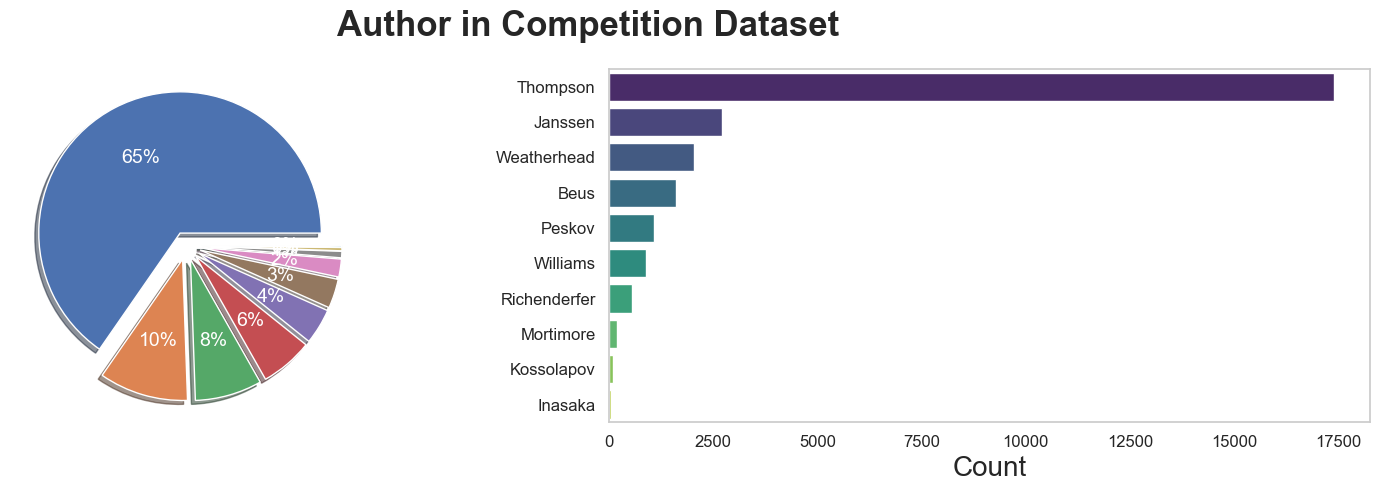

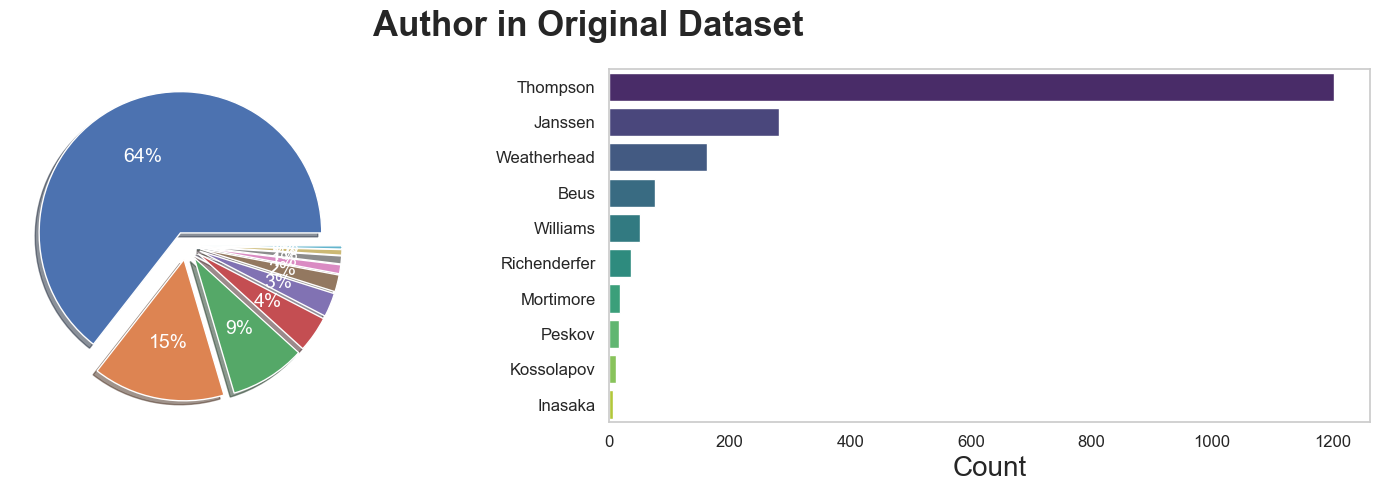

In [215]:
# author dataset competition
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
ax = ax.flatten()

ax[0].pie(
    data['author'].value_counts(), 
    shadow = True, 
    explode = [.1 for i in range(0, 10)], 
    autopct = '%1.f%%',
    textprops = {'size' : 14, 'color' : 'white'}
)

sns.countplot(data = data, y = 'author', ax = ax[1], palette = 'viridis', order = data['author'].value_counts().index)
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize = 12)
ax[1].set_xlabel('Count', fontsize = 20)
ax[1].set_ylabel(None)
plt.xticks(fontsize = 12)

fig.suptitle('Author in Competition Dataset', fontsize = 25, fontweight = 'bold')
plt.tight_layout()


# author dataset original
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
ax = ax.flatten()

ax[0].pie(
    origin['author'].value_counts(), 
    shadow = True, 
    explode = [.1 for i in range(0, 10)], 
    autopct = '%1.f%%',
    textprops = {'size' : 14, 'color' : 'white'}
)

sns.countplot(data = origin, y = 'author', ax = ax[1], palette = 'viridis', order = origin['author'].value_counts().index)
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize = 12)
ax[1].set_xlabel('Count', fontsize = 20)
ax[1].set_ylabel(None)
plt.xticks(fontsize = 12)

fig.suptitle('Author in Original Dataset', fontsize = 25, fontweight = 'bold')
plt.tight_layout()

##### GEOMETRY

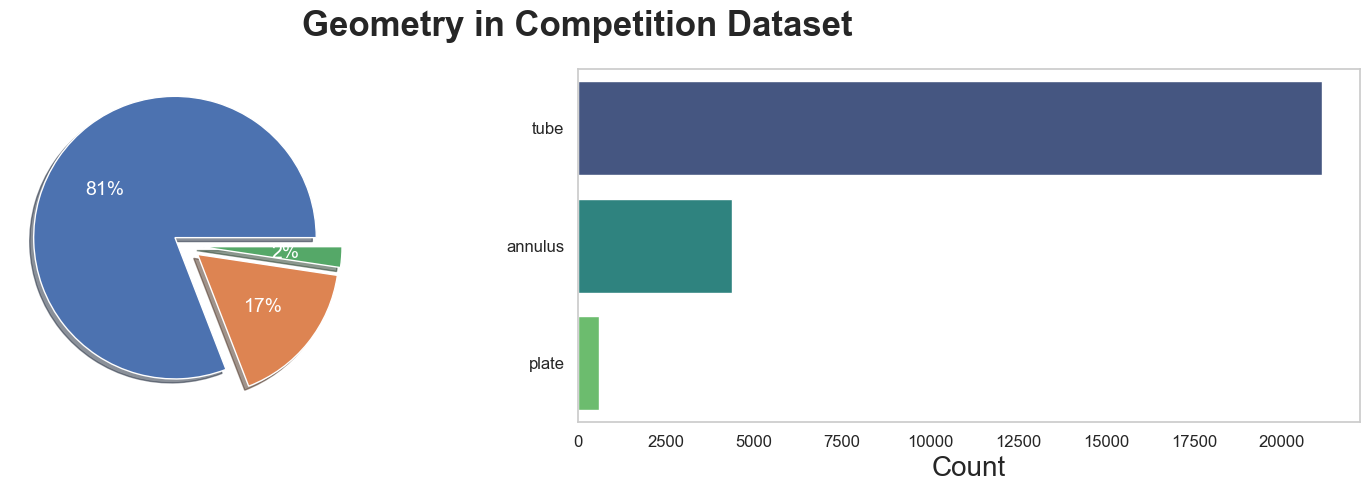

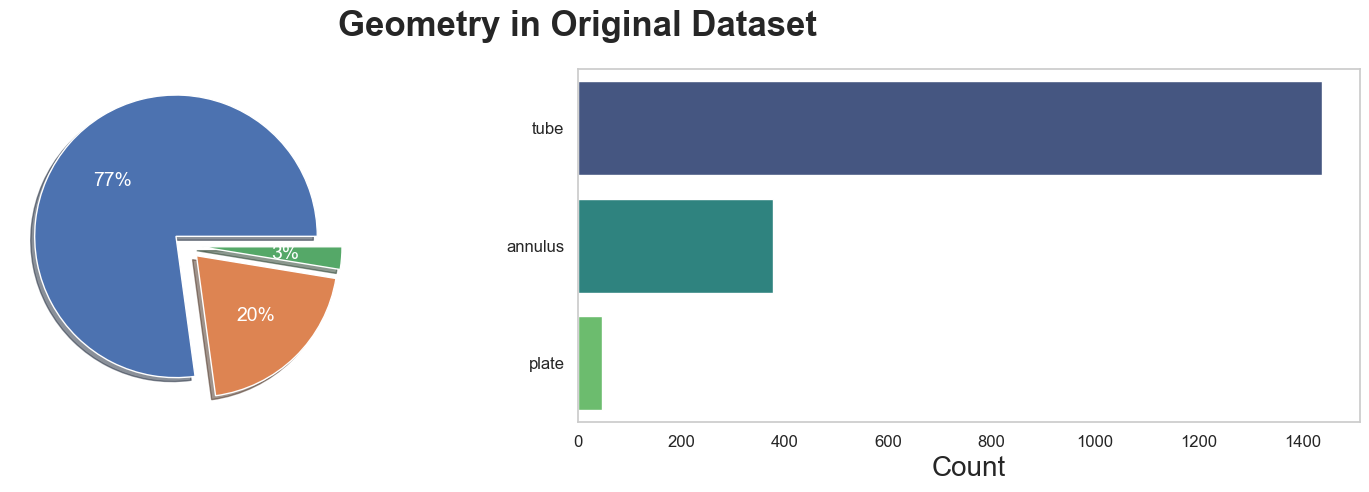

In [216]:
# geometry dataset competition
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
ax = ax.flatten()

ax[0].pie(
    data['geometry'].value_counts(), 
    shadow = True, 
    explode = [.1 for i in range(0, 3)], 
    autopct = '%1.f%%',
    textprops = {'size' : 14, 'color' : 'white'}
)

sns.countplot(data = data, y = 'geometry', ax = ax[1], palette = 'viridis')
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize = 12)
ax[1].set_xlabel('Count', fontsize = 20)
ax[1].set_ylabel(None)
plt.xticks(fontsize = 12)

fig.suptitle('Geometry in Competition Dataset', fontsize = 25, fontweight = 'bold')
plt.tight_layout()


# geometry dataset original
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
ax = ax.flatten()

ax[0].pie(
    origin['geometry'].value_counts(), 
    shadow = True, 
    explode = [.1 for i in range(0, 3)], 
    autopct = '%1.f%%',
    textprops = {'size' : 14, 'color' : 'white'}
)

sns.countplot(data = origin, y = 'geometry', ax = ax[1], palette = 'viridis')
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize = 12)
ax[1].set_xlabel('Count', fontsize = 20)
ax[1].set_ylabel(None)
plt.xticks(fontsize = 12)

fig.suptitle('Geometry in Original Dataset', fontsize = 25, fontweight = 'bold')
plt.tight_layout()

* **📝 Como podemos ver, ambas columnas tienen una categoría dominante y es apropiado asignarles los valores más comunes a los datos faltantes; es decir, vamos a imputar los missing values de las dos columnas categóricas con la moda.**

#### 📊 Relación entre D_e [mm] y D_h [mm] en función de 'geometry'

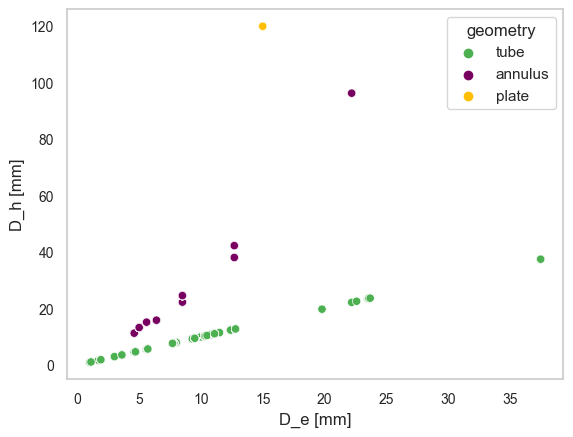

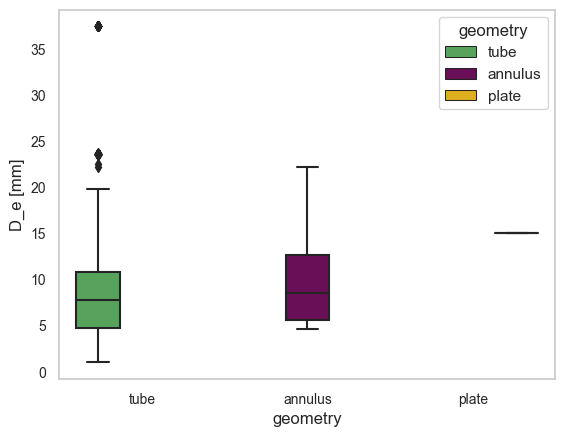

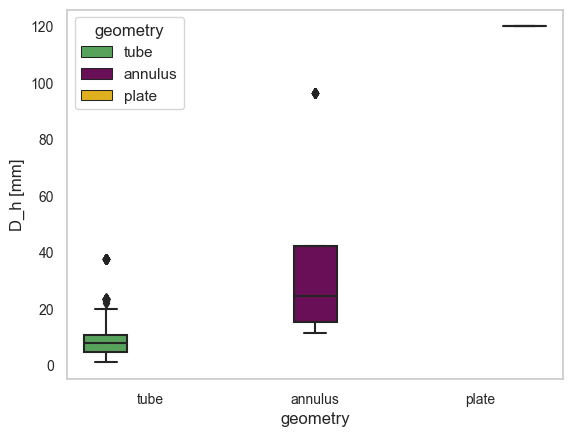

In [254]:
'''Para dataset ORIGINAL'''
# Gráfico de dispersión
sns.scatterplot(data=origin, x='D_e [mm]', y='D_h [mm]', hue='geometry', palette=color_pal)
plt.show()
# Gráfico de caja y bigotes
sns.boxplot(data=origin, x='geometry', y='D_e [mm]', hue='geometry', palette=color_pal)
plt.show()
sns.boxplot(data=origin, x='geometry', y='D_h [mm]', hue='geometry', palette=color_pal)
plt.show()

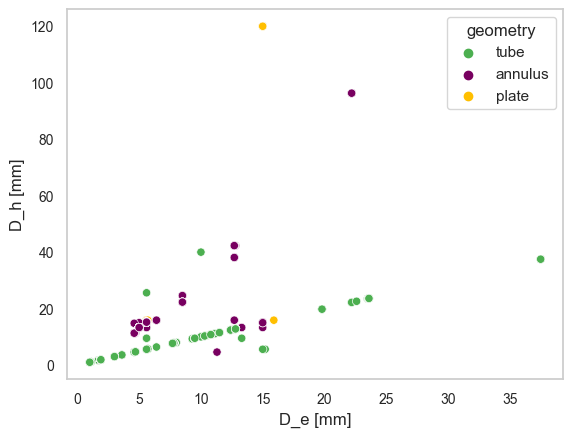

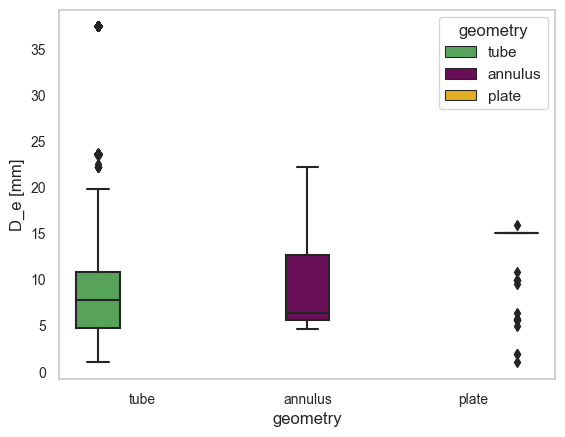

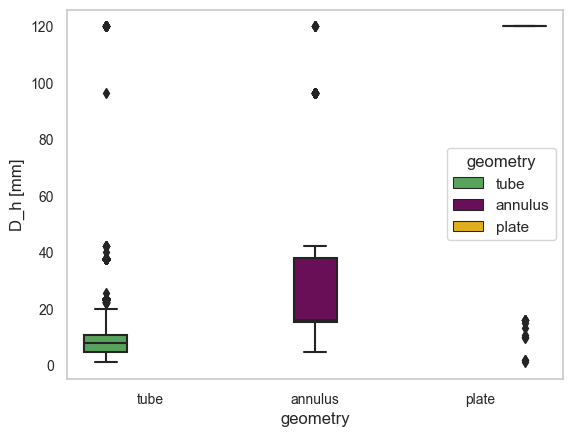

In [255]:
'''Para dataset GENERADO'''
# Gráfico de dispersión
sns.scatterplot(data=data, x='D_e [mm]', y='D_h [mm]', hue='geometry', palette=color_pal)
plt.show()
# Gráfico de caja y bigotes
sns.boxplot(data=data, x='geometry', y='D_e [mm]', hue='geometry', palette=color_pal)
plt.show()
sns.boxplot(data=data, x='geometry', y='D_h [mm]', hue='geometry', palette=color_pal)
plt.show()

In [256]:
'''DATASET GENERADO'''
# Vamos a calcular la correlación entre 'D_e [mm]' y 'D_h [mm]' en función de 'geometry'
geometries = data['geometry'].dropna().unique()
for geometry in geometries:
    corr = data[data['geometry'] == geometry][['D_e [mm]', 'D_h [mm]']].corr().iloc[0,1]
    print(f'Correlación lineal entre D_e [mm] y D_h [mm] para {geometry}: {corr}')

Correlación lineal entre D_e [mm] y D_h [mm] para tube: 0.7587327805181661
Correlación lineal entre D_e [mm] y D_h [mm] para annulus: 0.9496514552518556
Correlación lineal entre D_e [mm] y D_h [mm] para plate: 0.9067414004839732


In [257]:
'''DATASET ORIGINAL'''
# Vamos a calcular la correlación entre 'D_e [mm]' y 'D_h [mm]' en función de 'geometry'
geometries = origin['geometry'].dropna().unique()
for geometry in geometries:
    corr = origin[origin['geometry'] == geometry][['D_e [mm]', 'D_h [mm]']].corr().iloc[0,1]
    print(f'Correlación lineal entre D_e [mm] y D_h [mm] para {geometry}: {corr}')

Correlación lineal entre D_e [mm] y D_h [mm] para tube: 1.0
Correlación lineal entre D_e [mm] y D_h [mm] para annulus: 0.979177416089442
Correlación lineal entre D_e [mm] y D_h [mm] para plate: nan


geometry  D_e [mm]  D_h [mm]
tube      10.3      10.3        1880
          10.8      10.8        1790
          4.7       4.7         1754
          1.9       1.9         1723
          7.7       7.7         1642
annulus   5.6       15.2        1053
tube      7.8       7.8          913
          10.0      10.0         753
          9.5       9.5          604
annulus   12.7      42.3         585
tube      11.1      11.1         537
          23.6      23.6         445
          11.5      11.5         433
annulus   12.7      38.1         430
plate     15.0      120.0        420
tube      4.6       4.6          414
          5.6       5.6          388
          3.0       3.0          328
annulus   6.4       15.9         293
tube      5.7       5.7          269
annulus   8.5       22.3         255
tube      12.8      12.8         255
          37.5      37.5         194
          3.6       3.6          186
annulus   8.5       24.6         168
          5.0       13.3         128
tube     

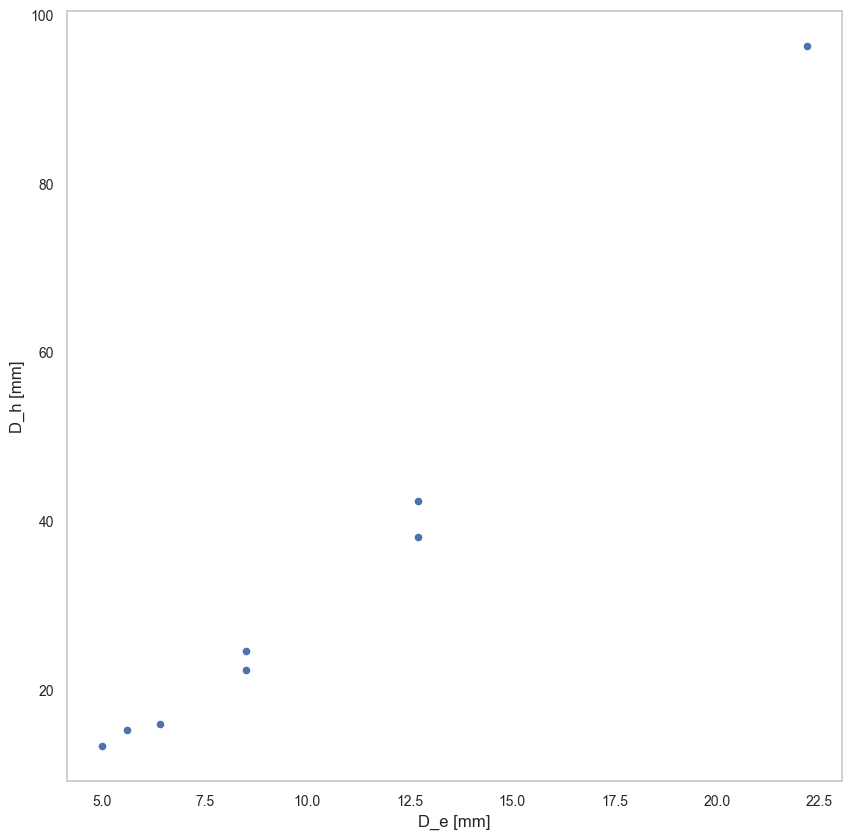

In [258]:
'''AVERIGUAMOS EL PATRÓN DE LOS DATOS'''


pd.set_option('display.max_rows', None)

print(data.groupby(['geometry', 'D_e [mm]', 'D_h [mm]'])['id'].count().sort_values(ascending=False))

df = pd.DataFrame(data.groupby(['geometry', 'D_e [mm]', 'D_h [mm]'])['id'].count())
df.reset_index(inplace=True)
sr = df.groupby(['geometry', 'D_e [mm]', 'D_h [mm]'])['id'].max()
sr_aux = pd.DataFrame(sr.sort_values(ascending=False).iloc[:30]).reset_index()
sr_aux[sr_aux["geometry"]=="annulus"].plot(y="D_h [mm]", x="D_e [mm]", kind="scatter", figsize=(10, 10))
plt.show()

##### DATASET GENERADO (OBSERVACIONES):
* **Cuando 'geometry' es 'tube', los valores de 'D_e [mm]' y 'D_h [mm]' son prácticamente iguales, con pequeñas variaciones en los decimales.**

* **Cuando 'geometry' es 'annulus', los valores de 'D_h [mm]' son generalmente mayores que los valores de 'D_e [mm]'.**

* **Para la categoría 'plate', solo hay un caso registrado y los valores de 'D_h [mm]' y 'D_e [mm]' son iguales.** (15, 120)

### 📌RESUMEN IMPUTACIÓN:
* **📝 Imputamos los datos de geometry según el patrón seguido para cuando D_e [mm] y D_h [mm] son valores informados.**
* **📝 Vamos a imputar los missing values de las columnas categoricas con la moda.** ``geometry`` y ``author``.
* **📝 Vamos a imputar los missing values de las columnas numéricas no correlacionadas linealmente con KNN.** 
* **📝 Vamos a imputar los missing values de las columnas numéricas correlacionadas linealmente con regresión lineal.** ``D_h [mm]`` y ``D_e [mm]`` 

### 🧱📌Imputamos missing values en DATA

### **🔺Imputamos los datos de geometry según el patrón seguido para cuando D_e [mm] y D_h [mm] son valores informados.**

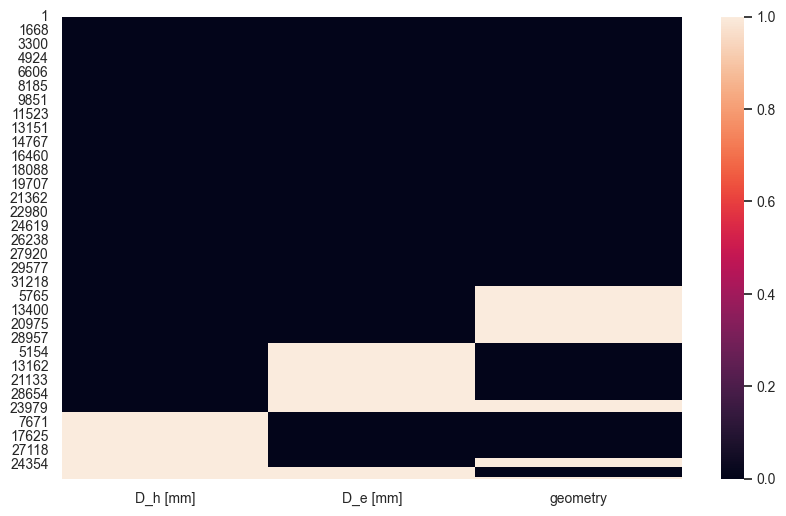

In [259]:
def plot_null_heatmap(df, cols_sort=None):
    plt.figure(figsize=(10, 6))
    if cols_sort is not None:
        sns.heatmap(df.isnull().sort_values(by=cols_sort), cbar=True)
    else:
        sns.heatmap(df.isnull(), cbar=True)
    plt.show()
plot_null_heatmap(data.loc[:, ["D_h [mm]", "D_e [mm]", "geometry"]], cols_sort=["D_h [mm]", "D_e [mm]", "geometry"])

In [260]:
# Quiero los valores null de 'geometry' para cuando 'D_h [mm]' y 'D_e [mm]' no son null
# null_geometry = data.loc[(data['D_h [mm]'].notnull()) & (data['D_e [mm]'].notnull()) & (data['geometry'].isnull())]
null_geometry = data.loc[(data['D_h [mm]'].notnull()) & (data['D_e [mm]'].notnull()) & (data['geometry'].isnull()), ['geometry', 'D_h [mm]', 'D_e [mm]']]
null_geometry.head()

geometry  D_h [mm]  D_e [mm]
2       NaN       7.7       7.7
6       NaN      12.8      12.8
19      NaN      15.9       6.4
27      NaN      11.1      11.1
51      NaN       1.9       1.9

In [261]:
# Filtrar las filas en null_geometry que cumplen las condiciones
null_geometry.loc[(null_geometry['D_e [mm]'] == 15.0) & (null_geometry['D_h [mm]'] == 120), 'geometry'] = 'plate'
null_geometry.loc[null_geometry['D_e [mm]'] == null_geometry['D_h [mm]'], 'geometry'] = 'tube'
null_geometry.loc[null_geometry['geometry'].isnull(), 'geometry'] = 'annulus'

# Verificar los cambios
null_geometry

# Actualizar los valores en el dataframe original (data) usando los cambios realizados en null_geometry
data.update(null_geometry)

data['geometry'].isnull().sum()

1581

### 💡Ahora quiero ver el patrón que siguen los datos **generados** en cuanto geometry, d_h y d_e

geometry  D_e [mm]  D_h [mm]
tube      10.3      10.3        2312
          10.8      10.8        2172
          1.9       1.9         2110
          4.7       4.7         2098
          7.7       7.7         1959
annulus   5.6       15.2        1272
tube      7.8       7.8         1099
          10.0      10.0         932
          9.5       9.5          754
annulus   12.7      42.3         703
tube      11.1      11.1         652
          23.6      23.6         552
          11.5      11.5         524
annulus   12.7      38.1         517
plate     15.0      120.0        514
tube      4.6       4.6          500
          5.6       5.6          462
          3.0       3.0          407
annulus   6.4       15.9         352
tube      5.7       5.7          329
annulus   8.5       22.3         313
tube      12.8      12.8         303
          3.6       3.6          231
          37.5      37.5         229
annulus   8.5       24.6         199
          5.0       13.3         160
tube     

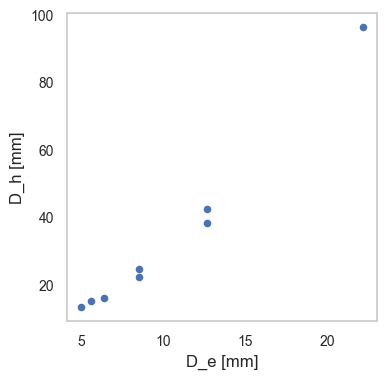

In [262]:
pd.set_option('display.max_rows', None)

print(data.groupby(['geometry', 'D_e [mm]', 'D_h [mm]'])['id'].count().sort_values(ascending=False))

df_data = pd.DataFrame(data.groupby(['geometry', 'D_e [mm]', 'D_h [mm]'])['id'].count())
df_data.reset_index(inplace=True)
sr_data = df_data.groupby(['geometry', 'D_e [mm]', 'D_h [mm]'])['id'].max()
sr_aux_data = pd.DataFrame(sr_data.sort_values(ascending=False).iloc[:30]).reset_index()
sr_aux_data[sr_aux_data["geometry"]=="annulus"].plot(y="D_h [mm]", x="D_e [mm]", kind="scatter", figsize=(4, 4))
plt.show()

### 💡Ahora quiero ver el patrón que siguen los datos **originales** en cuanto geometry, d_h y d_e

geometry  D_e [mm]  D_h [mm]
tube      7.7       7.7         188
          10.3      10.3        179
          1.9       1.9         150
          4.7       4.7         137
          10.8      10.8         92
annulus   12.7      42.3         91
tube      4.6       4.6          78
annulus   5.6       15.2         77
tube      23.6      23.6         72
          7.8       7.8          70
          11.5      11.5         68
          11.1      11.1         68
annulus   12.7      38.1         51
tube      9.5       9.5          51
annulus   8.5       22.3         50
plate     15.0      120.0        48
tube      5.6       5.6          46
          37.5      37.5         40
annulus   8.5       24.6         38
tube      9.3       9.3          31
          12.8      12.8         29
          5.7       5.7          28
annulus   6.4       15.9         25
tube      3.0       3.0          20
          3.6       3.6          19
annulus   5.0       13.3         19
tube      1.0       1.0          17

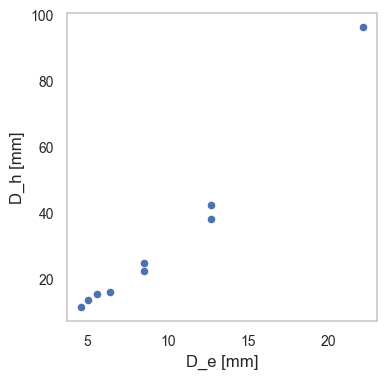

In [263]:
pd.set_option('display.max_rows', None)

print(origin.groupby(['geometry', 'D_e [mm]', 'D_h [mm]'])['id'].count().sort_values(ascending=False))

df = pd.DataFrame(origin.groupby(['geometry', 'D_e [mm]', 'D_h [mm]'])['id'].count())
df.reset_index(inplace=True)
sr = df.groupby(['geometry', 'D_e [mm]', 'D_h [mm]'])['id'].max()
sr_aux = pd.DataFrame(sr.sort_values(ascending=False).iloc[:30]).reset_index()
sr_aux[sr_aux["geometry"]=="annulus"].plot(y="D_h [mm]", x="D_e [mm]", kind="scatter", figsize=(4, 4))
plt.show()

### **🔺Imputamos los missing values de las columnas categoricas con la moda.** ``geometry`` y ``author``.
### **🔺Imputamos los missing values de las columnas numéricas no correlacionadas linealmente con KNN.** 

In [264]:
import warnings
warnings.filterwarnings("ignore")

# Creamos un pipeline para imputar los missing values tanto de las variables numéricas como de las categóricas
categorical_imputer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
])

data_cat_imputed = categorical_imputer.fit_transform(data[cat_cols])
data[cat_cols] = pd.DataFrame(data_cat_imputed, columns=cat_cols)

# Creamos un pipeline para imputar los missing values de las variables numéricas que no siguen relación lineal
numerical_no_lineal = ['pressure [MPa]', 'mass_flux [kg/m2-s]', 'length [mm]']
knn_imputer = Pipeline([
     ('imputer', KNNImputer(n_neighbors=5, weights='uniform')),
])
data_nonlin_num_imputed = knn_imputer.fit_transform(data[numerical_no_lineal])
data[numerical_no_lineal] = pd.DataFrame(data_nonlin_num_imputed, columns=numerical_no_lineal)

In [265]:
# Comprobamos que se han imputado correctamente
print(data['pressure [MPa]'].isnull().sum())
print(data['mass_flux [kg/m2-s]'].isnull().sum())
print(data['length [mm]'].isnull().sum())
# cat_cols = ['geometry', 'author']
print(data[cat_cols].isnull().sum())

0
0
0
author      0
geometry    0
dtype: int64


### **🔺Vamos a imputar los missing values de las columnas numéricas correlacionadas linealmente con regresión lineal.** ``D_h [mm]`` y ``D_e [mm]`` en base a la columna categórica ``Geometry``.

#### 📝 Geometry == 'plate'

In [266]:
pd.set_option('display.max_rows', None)
print(data[data['geometry'] == 'plate'][['D_e [mm]', 'D_h [mm]']])

       D_e [mm]  D_h [mm]
108        15.0     120.0
133         NaN     120.0
156        15.0       NaN
176        15.0     120.0
235        15.0     120.0
287         NaN     120.0
417        15.0       NaN
456        15.0     120.0
479        15.0       NaN
490        15.0     120.0
523        15.0       NaN
592        15.0     120.0
593        15.0     120.0
657        15.0     120.0
680        15.0     120.0
754         NaN     120.0
799        15.0     120.0
879         NaN     120.0
880        15.0       NaN
910        15.0     120.0
969        15.0       NaN
996        15.0     120.0
1115       15.0     120.0
1120       15.0     120.0
1257       15.0     120.0
1260       15.0       NaN
1261       15.0     120.0
1293       15.0     120.0
1343        NaN       NaN
1392       15.0     120.0
1420       15.0     120.0
1542       15.0     120.0
1560       15.0     120.0
1631       15.0     120.0
1679        NaN     120.0
1705       15.0     120.0
1724       15.0       NaN
1769       1

In [267]:
data.loc[(data['geometry'] == 'plate') & data['D_e [mm]'].isnull(), 'D_e [mm]'] = 15.0
data.loc[(data['geometry'] == 'plate') & data['D_h [mm]'].isnull(), 'D_h [mm]'] = 120.0

#### 📝 Geometry == 'tube'

In [268]:
pd.set_option('display.max_rows', None)
print(data[data['geometry'] == 'tube'][['D_e [mm]', 'D_h [mm]']])

       D_e [mm]  D_h [mm]
0           NaN      10.8
1          10.3      10.3
2           7.7       7.7
4          11.1      11.1
5           NaN       1.9
6          12.8      12.8
7          10.0      10.0
8           NaN       NaN
9          10.0      10.0
10          1.9       1.9
12          NaN      12.8
13         10.0       NaN
14          1.9       1.9
15          1.9       1.9
16         10.8      10.8
17          4.6       4.6
18          NaN      10.8
20         10.3      10.3
21          1.9       1.9
22         11.1      11.1
24          7.8       7.8
25          4.7       NaN
26          1.9       NaN
27         11.1      11.1
28          7.8       7.8
29          7.7       7.7
31         10.0      10.0
32          7.8       7.8
33          5.6       NaN
34          NaN       7.8
35          NaN      11.1
36          7.7       7.7
38          4.7       NaN
39          5.7       5.7
40          3.0       NaN
41          7.7       7.7
42          9.3       9.3
43          

In [269]:
data.loc[data['geometry'] == 'tube', 'D_h [mm]'] = data.loc[data['geometry'] == 'tube', 'D_e [mm]']
print(data[data['geometry'] == 'tube'][['D_e [mm]', 'D_h [mm]']])

       D_e [mm]  D_h [mm]
0           NaN       NaN
1          10.3      10.3
2           7.7       7.7
4          11.1      11.1
5           NaN       NaN
6          12.8      12.8
7          10.0      10.0
8           NaN       NaN
9          10.0      10.0
10          1.9       1.9
12          NaN       NaN
13         10.0      10.0
14          1.9       1.9
15          1.9       1.9
16         10.8      10.8
17          4.6       4.6
18          NaN       NaN
20         10.3      10.3
21          1.9       1.9
22         11.1      11.1
24          7.8       7.8
25          4.7       4.7
26          1.9       1.9
27         11.1      11.1
28          7.8       7.8
29          7.7       7.7
31         10.0      10.0
32          7.8       7.8
33          5.6       5.6
34          NaN       NaN
35          NaN       NaN
36          7.7       7.7
38          4.7       4.7
39          5.7       5.7
40          3.0       3.0
41          7.7       7.7
42          9.3       9.3
43          

#### 📝 Geometry == 'annulus'

##### ✅ D_h [mm] = k * D_e [mm]

####  🌟PROBAMOS A HACER LA REGRESIÓN LINEAL CON EL DATASET ORIGINAL

In [270]:
'''
Vamos a establecer una regresión lineal entre las variables 'D_e [mm]' y 'D_h [mm]' para geometry = 'annulus'.
'''

from sklearn.linear_model import LinearRegression

# Filtra los datos para seleccionar las filas donde 'geometry' es igual a 'annulus' y no hay valores nulos en 'D_e [mm]' y 'D_h [mm]'
filtered_data_origin = origin[(origin['geometry'] == 'annulus') & origin['D_e [mm]'].notnull() & origin['D_h [mm]'].notnull()]

# Obtén las columnas 'D_e [mm]' y 'D_h [mm]' como variables independientes y dependientes, respectivamente
X = filtered_data_origin[['D_e [mm]']]
y = filtered_data_origin['D_h [mm]']

# Crea un objeto de regresión lineal
regression_origin = LinearRegression()

# Ajusta el modelo de regresión lineal a los datos
regression_origin.fit(X, y)

# Obtiene el valor de 'k' (coeficiente de la variable 'D_e [mm]')
k_origin = regression_origin.coef_[0]

print(f"El valor de 'k' para la relación lineal 'D_h [mm] = k_origin * D_e [mm]' en la categoría 'annulus' es: {k_origin}")

El valor de 'k' para la relación lineal 'D_h [mm] = k_origin * D_e [mm]' en la categoría 'annulus' es: 4.307381844408128


####  🌟PROBAMOS A HACER LA REGRESIÓN LINEAL CON EL DATASET GENERADO

In [156]:
# '''
# Vamos a establecer una regresión lineal entre las variables 'D_e [mm]' y 'D_h [mm]' para geometry = 'annulus'.
# '''

# from sklearn.linear_model import LinearRegression

# # Filtra los datos para seleccionar las filas donde 'geometry' es igual a 'annulus' y no hay valores nulos en 'D_e [mm]' y 'D_h [mm]'
# filtered_data = data[(data['geometry'] == 'annulus') & data['D_e [mm]'].notnull() & data['D_h [mm]'].notnull()]

# # Obtén las columnas 'D_e [mm]' y 'D_h [mm]' como variables independientes y dependientes, respectivamente
# X = filtered_data[['D_e [mm]']]
# y = filtered_data['D_h [mm]']

# # Crea un objeto de regresión lineal
# regression = LinearRegression()

# # Ajusta el modelo de regresión lineal a los datos
# regression.fit(X, y)

# # Obtiene el valor de 'k' (coeficiente de la variable 'D_e [mm]')
# k = regression.coef_[0]

# print(f"El valor de 'k' para la relación lineal 'D_h [mm] = k * D_e [mm]' en la categoría 'annulus' es: {k}")

In [271]:
'''La k_origin optima es 4.307381844408128. DATASET ORIGINAL.
Vamos a establecer una regresión lineal entre las variables 'D_e [mm]' y 'D_h [mm]' para geometry = 'annulus'.'''
# Filtramos los datos para seleccionar las filas donde 'geometry' es igual a 'annulus' y hay valores nulos en 'D_h [mm]'
null_rows = data[(data['geometry'] == 'annulus') & data['D_h [mm]'].isnull()]
# Imputamos los valores nulos en 'D_h [mm]' utilizando la relación lineal 'D_h [mm] = k * D_e [mm]'
data.loc[null_rows.index, 'D_h [mm]'] = k_origin * data.loc[null_rows.index, 'D_e [mm]']
# Verificamos los cambios
print(data[data['geometry'] == 'annulus'][['D_e [mm]', 'D_h [mm]']])

       D_e [mm]    D_h [mm]
3           5.6   15.200000
11         12.7   54.703749
19          6.4   15.900000
23          5.6   15.200000
30         12.7   38.100000
37         12.7   54.703749
49          NaN   15.200000
53          5.6   15.200000
63         12.7   38.100000
67          6.4   15.900000
70          5.0   13.300000
77          5.0   21.536909
80          8.5   22.300000
85          5.6   24.121338
97         22.2   96.300000
101         6.4   15.900000
102         5.6   24.121338
120        12.7   54.703749
125        12.7   38.100000
126         5.6   24.121338
129         NaN   42.300000
141        12.7   38.100000
155         5.6   15.200000
166         5.6   24.121338
171         4.6   11.300000
173         NaN   15.200000
197        12.7   38.100000
206        12.7   42.300000
207        12.7   38.100000
211         NaN   15.200000
215         5.6   24.121338
216         5.6   15.200000
226         5.6   15.200000
230         6.4   15.900000
234        12.7   42

##### ❌ D_e [mm] = a + b * D_h [mm]// Regresión lineal inversa**

####  🌟PROBAMOS A HACER LA REGRESIÓN LINEAL INVERSA CON EL DATASET ORIGINAL

In [272]:
# Filtra los datos para seleccionar las filas donde 'geometry' es igual a 'annulus' y no hay valores nulos en 'D_e [mm]' y 'D_h [mm]'(en realidad son todas porque no hay valores nulos)
filtered_data_inverse_origin = origin[(origin['geometry'] == 'annulus') & origin['D_e [mm]'].notnull() & origin['D_h [mm]'].notnull()]
# Obtenemos las columnas 'D_h [mm]' y 'D_e [mm]' como variables independientes y dependientes, respectivamente
X_origin = filtered_data_inverse_origin[['D_h [mm]']] #filtered_data
y_origin = filtered_data_inverse_origin['D_e [mm]'] # filtered_data
# Instanciamos regresión lineal
regression_inverse_origin = LinearRegression()
# Ajustamos el modelo de regresión lineal a los datos
regression_inverse_origin.fit(X_origin, y_origin)
# Obtenemos el valor de 'a' (intercepto) y 'b' (coeficiente de la variable 'D_h [mm]')
a_origin = regression_inverse_origin.intercept_
b_origin = regression_inverse_origin.coef_[0]
print(f"La ecuación de la regresión lineal inversa 'D_e [mm] = a + b * D_h [mm]' en la categoría 'annulus' para el dataset original es:")
print(f"D_e [mm] = {a_origin:.4f} + {b_origin:.4f} * D_h [mm]")

La ecuación de la regresión lineal inversa 'D_e [mm] = a + b * D_h [mm]' en la categoría 'annulus' para el dataset original es:
D_e [mm] = 2.9750 + 0.2226 * D_h [mm]


In [273]:
null_rows_inverse = data[(data['geometry'] == 'annulus') & data['D_e [mm]'].isnull()]
# Imputar los valores nulos en 'D_h [mm]' utilizando la regresión lineal inversa
data.loc[null_rows_inverse.index, 'D_e [mm]'] = a_origin + b_origin * data.loc[null_rows_inverse.index, 'D_h [mm]']
# Verificar los cambios
print(data[data['geometry'] == 'annulus'][['D_e [mm]', 'D_h [mm]']])

        D_e [mm]    D_h [mm]
3       5.600000   15.200000
11     12.700000   54.703749
19      6.400000   15.900000
23      5.600000   15.200000
30     12.700000   38.100000
37     12.700000   54.703749
49      6.358375   15.200000
53      5.600000   15.200000
63     12.700000   38.100000
67      6.400000   15.900000
70      5.000000   13.300000
77      5.000000   21.536909
80      8.500000   22.300000
85      5.600000   24.121338
97     22.200000   96.300000
101     6.400000   15.900000
102     5.600000   24.121338
120    12.700000   54.703749
125    12.700000   38.100000
126     5.600000   24.121338
129    12.390616   42.300000
141    12.700000   38.100000
155     5.600000   15.200000
166     5.600000   24.121338
171     4.600000   11.300000
173     6.358375   15.200000
197    12.700000   38.100000
206    12.700000   42.300000
207    12.700000   38.100000
211     6.358375   15.200000
215     5.600000   24.121338
216     5.600000   15.200000
226     5.600000   15.200000
230     6.4000

In [274]:
print(data['pressure [MPa]'].isnull().sum())                                            # ✔️
print(data['mass_flux [kg/m2-s]'].isnull().sum())                                       # ✔️
print(data['length [mm]'].isnull().sum())                                               # ✔️
# cat_cols = ['geometry', 'author']
print(data[cat_cols].isnull().sum())                                                    # ✔️
# vemos los valores nulos de D_e y D_h cuando geometry es igual plate
print(data[data['geometry'] == 'plate'][['D_e [mm]', 'D_h [mm]']].isnull().sum())       # ✔️
# Vemos los valores de D_e y D_h cuando geometry es igual tube
print(data[data['geometry'] == 'tube'][['D_e [mm]', 'D_h [mm]']].isnull().sum())        # ✔️
# Vemos los valores de D_e y D_h cuando geometry es igual annulus
print(data[data['geometry'] == 'annulus'][['D_e [mm]', 'D_h [mm]']].isnull().sum())     # ✔️

0
0
0
author      0
geometry    0
dtype: int64
D_e [mm]    0
D_h [mm]    0
dtype: int64
D_e [mm]    4607
D_h [mm]    4607
dtype: int64
D_e [mm]    138
D_h [mm]    138
dtype: int64


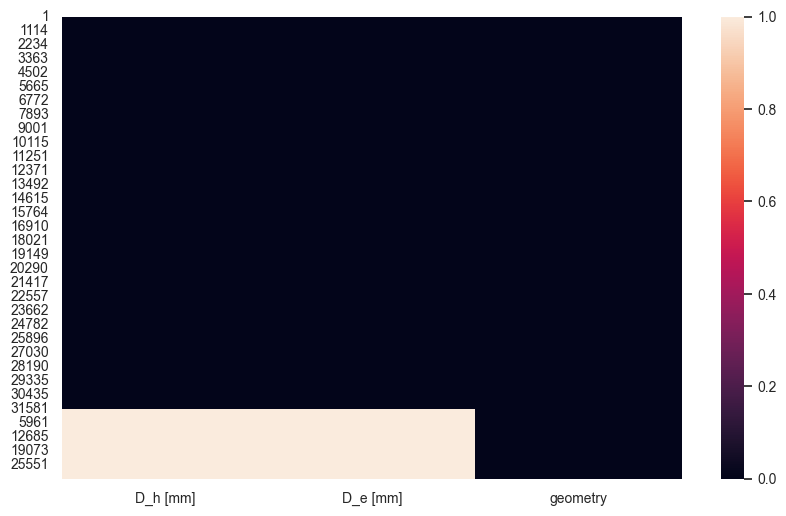

In [275]:
def plot_null_heatmap(df, cols_sort=None):
    plt.figure(figsize=(10, 6))
    if cols_sort is not None:
        sns.heatmap(df.isnull().sort_values(by=cols_sort), cbar=True)
    else:
        sns.heatmap(df.isnull(), cbar=True)
    plt.show()
plot_null_heatmap(data.loc[:, ["D_h [mm]", "D_e [mm]", "geometry"]], cols_sort=["D_h [mm]", "D_e [mm]", "geometry"])

In [277]:
'''O las eliminamos o usamos KNNImputer'''
null_geometry = data.loc[(data['D_h [mm]'].isnull()) & (data['D_e [mm]'].isnull()) & (data['geometry'].notnull()), ['geometry', 'D_h [mm]', 'D_e [mm]']]
null_geometry.head()

geometry  D_h [mm]  D_e [mm]
0      tube       NaN       NaN
5      tube       NaN       NaN
8      tube       NaN       NaN
12     tube       NaN       NaN
18     tube       NaN       NaN

#### 🌟KNN Imputer para la columna 'D_e [mm]' en la categoría 'annulus'

**MÉTODO:** Usamos KNN Imputer basándonos en el datset original para imputar las columnas ``D_e [mm]`` y ``D_h [mm]`` con missing values en el dataset generado.

In [278]:
X_knn_origin = origin[['D_e [mm]', 'D_h [mm]']]
X_knn_generado = data[['D_e [mm]', 'D_h [mm]']]
# Creamos una instancia de KNNImputer con los parámetros deseados
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')

# Realizamos la imputación de los valores en el dataset origin
imputed_origin = knn_imputer.fit_transform(X_knn_origin)

# Utilizamos el modelo KNNImputer entrenado en el dataset origin para imputar los valores en el dataset generado
imputed_data = knn_imputer.transform(X_knn_generado)

# Asignamos los valores imputados al DataFrame data
data['D_e [mm]'] = imputed_data[:, 0]
data['D_h [mm]'] = imputed_data[:, 1]

In [279]:
print(data['pressure [MPa]'].isnull().sum())                                            # ✔️
print(data['mass_flux [kg/m2-s]'].isnull().sum())                                       # ✔️
print(data['length [mm]'].isnull().sum())                                               # ✔️
# cat_cols = ['geometry', 'author']
print(data[cat_cols].isnull().sum())                                                    # ✔️
# vemos los valores nulos de D_e y D_h cuando geometry es igual plate
print(data[data['geometry'] == 'plate'][['D_e [mm]', 'D_h [mm]']].isnull().sum())       # ✔️
# Vemos los valores de D_e y D_h cuando geometry es igual tube
print(data[data['geometry'] == 'tube'][['D_e [mm]', 'D_h [mm]']].isnull().sum())        # ✔️
# Vemos los valores de D_e y D_h cuando geometry es igual annulus
print(data[data['geometry'] == 'annulus'][['D_e [mm]', 'D_h [mm]']].isnull().sum())     # ✔️

0
0
0
author      0
geometry    0
dtype: int64
D_e [mm]    0
D_h [mm]    0
dtype: int64
D_e [mm]    0
D_h [mm]    0
dtype: int64
D_e [mm]    0
D_h [mm]    0
dtype: int64


In [280]:
summary_table(data)

data shape: (31644, 10)


%missing         mean         std    median
author                0.000000          NaN         NaN       NaN
geometry              0.000000          NaN         NaN       NaN
pressure [MPa]        0.000000    10.635348    4.254946    11.052
mass_flux [kg/m2-s]   0.000000  3068.151022  1706.52392    2760.0
x_e_out [-]          32.913032    -0.000453    0.100911    0.0038
D_e [mm]              0.000000     8.769944    4.763369  9.417212
D_h [mm]              0.000000    15.013763   18.951536      10.3
length [mm]           0.000000   849.389854  657.188656     625.0
chf_exp [MW/m2]       0.000000     3.796985    1.983991       3.4

In [281]:
summary_table(origin)

data shape: (1865, 10)


%missing         mean          std  median
author                    0.0          NaN          NaN     NaN
geometry                  0.0          NaN          NaN     NaN
pressure [MPa]            0.0    10.010949     4.282715   10.34
mass_flux [kg/m2-s]       0.0  2862.647721  1656.412247  2590.0
x_e_out [-]               0.0     0.016179     0.117575  0.0244
D_e [mm]                  0.0     9.417212     6.333807     8.5
D_h [mm]                  0.0    16.167721     21.18287    10.3
length [mm]               0.0   911.340483   726.718974   625.0
chf_exp [MW/m2]           0.0     3.854638     1.985535     3.5

### 📌 Convertimos las variables categóricas en numéricas

In [282]:
data = pd.get_dummies(data, columns=cat_cols, drop_first=True)

### 📌 Pasamos nuestra variable data modificada a un csv para poder utilizarla en el notebook de modelado

In [287]:
# Guardamos el DataFrame en un archivo csv
ruta = '../data/data_imputed/data_processed_newdata2.csv'
data.to_csv(ruta, index=False)